Multilabel Classification with SVM and Overfitting Check

In [23]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

sns.set(style="whitegrid")

In [29]:

def check_multiple_labels(issue):
    stance_groups = {
        'brexit': ['pro_brexit', 'anti_brexit'],
        'ClimateChangeUK': ['pro_climateAction', 'anti_climateAction'],
        'HealthcareUK': ['pro_NHS', 'anti_NHS'],
        'IsraelPalestineUK': ['pro_israel', 'pro_palestine'],
        'TaxationUK': ['pro_company_taxation', 'pro_worker_taxation'],
        'ImmigrationUS': ['pro_immigration','anti_immigration']
    }
    
    if issue not in stance_groups:
        raise ValueError(f"Unknown issue: {issue}")
    
    targets = stance_groups[issue] + ['neutral', 'irrelevant']
    
    file_path = '/Users/adamzulficar/Documents/year3/Bachelor Project/Thesis/Automated Annotation/Training Data/US/{}_training.csv'.format(issue)
    df = pd.read_csv(file_path)

    df['num_labels'] = df[targets].sum(axis=1)
    multi_label_rows = df[df['num_labels'] > 1]
    
    if not multi_label_rows.empty:
        print("Rows with multiple stance labels:")
        print(multi_label_rows)
    else:
        print("No rows with multiple stance labels found.")
    
    return multi_label_rows

# Check for multiple labels in the ImmigrationUS issue
multi_label_rows = check_multiple_labels('ImmigrationUS')


Rows with multiple stance labels:
               subreddit     type      keyword       id  author title  \
232  PoliticalDiscussion  comment  Immigration  hrqbuk2  monjoe   NaN   

                                                  body  \
232  That was the original immigration policy, yes....   

                   created_utc   parent_id  pro_immigration  anti_immigration  \
232  2022-01-08T03:16:06+00:00  t1_hrq5je0              1.0               0.0   

     neutral  irrelevant                                               text  \
232      1.0         0.0  ['original', 'immigration', 'policy', 'yes', '...   

                                              text_raw  \
232  that was the original immigration policy yes m...   

                                               context  \
232  ['would', 'solve', 'illegal', 'immigration', '...   

                                           context_raw  \
232  how would you solve illegal immigration and ho...   

                             

Data Preprocessing

In [30]:
def classify_issue(issue):
    stance_groups = {
        'brexit': ['pro_brexit', 'anti_brexit'],
        'ClimateChangeUK': ['pro_climateAction', 'anti_climateAction'],
        'HealthcareUK': ['pro_NHS', 'anti_NHS'],
        'IsraelPalestineUK': ['pro_israel', 'pro_palestine'],
        'TaxationUK': ['pro_company_taxation', 'pro_worker_taxation'],

        'ImmigrationUS': ['pro_immigration', 'anti_immigration'],
        'ClimateChangeUS': ['pro_climateAction', 'anti_climateAction'],
        'HealthcareUS': ['public_healthcare', 'private_healthcare'],
        'IsraelPalestineUS': ['pro_israel', 'pro_palestine'],
        'TaxationUS': ['pro_middle_low_tax', 'pro_wealthy_corpo_tax']
    }
    
    if issue not in stance_groups:
        raise ValueError(f"Unknown issue: {issue}")
    
    targets = stance_groups[issue] + ['neutral', 'irrelevant']

    file_path = '/Users/adamzulficar/Documents/year3/Bachelor Project/Thesis/Automated Annotation/Training Data/US/{}_training.csv'.format(issue)
    df = pd.read_csv(file_path)

    ## SMOTE ##

    def str_to_array(s):
        return np.fromstring(s.strip("[]"), sep=' ')

    features = df['text_vector'].apply(str_to_array).tolist()
    context = df['context_vector'].apply(str_to_array).tolist()
    X = np.array([np.concatenate((f, c)) for f, c in zip(features, context)])
    y_combined = df[targets].apply(lambda row: row[row == 1].index.tolist(), axis=1).tolist()

    mlb = MultiLabelBinarizer(classes=targets)
    y = mlb.fit_transform(y_combined)

    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)

    text_vector_length = len(str_to_array(df['text_vector'].iloc[0]))
    context_vector_length = len(str_to_array(df['context_vector'].iloc[0]))

    text_vectors_resampled = X_resampled[:, :text_vector_length]
    context_vectors_resampled = X_resampled[:, context_vector_length:]

    def array_to_str(arr):
        return ' '.join(map(str, arr))

    resampled_data = pd.DataFrame()
    resampled_data['text_vector'] = list(map(array_to_str, text_vectors_resampled))
    resampled_data['context_vector'] = list(map(array_to_str, context_vectors_resampled))

    for i, target in enumerate(targets):
        resampled_data[target] = y_resampled[:, i]

    data = resampled_data

    ## FEATURE VECTOR PROCESSING ##

    TEXT_VECTOR_SIZE = 100
    CONTEXT_VECTOR_SIZE = 1000

    def extract_vectors(row):
        text_vector = np.array(row['text_vector'].split(), dtype=float)
        context_vector = np.array(row['context_vector'].split(), dtype=float)

        if len(text_vector) > TEXT_VECTOR_SIZE:
            text_vector = text_vector[:TEXT_VECTOR_SIZE]
        else:
            text_vector = np.pad(text_vector, (0, TEXT_VECTOR_SIZE - len(text_vector)), 'constant')

        if len(context_vector) > CONTEXT_VECTOR_SIZE:
            context_vector = context_vector[:CONTEXT_VECTOR_SIZE]
        else:
            context_vector = np.pad(context_vector, (0, CONTEXT_VECTOR_SIZE - len(context_vector)), 'constant')

        return np.concatenate([text_vector, context_vector])
    
    ## MODEL ##

    X = data.apply(extract_vectors, axis=1)
    X = np.stack(X.values)
    y = data[targets].values

    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    pca = PCA(n_components=5)  # Reduce to 50 principal components
    X_pca = pca.fit_transform(X)
    
    return X_pca, y, targets

X_pca, y, targets = classify_issue('ImmigrationUS')



Model Training and Cross-Validation

In [17]:
def evaluate_model(X, y, stances, n_splits=10, random_state=42):
    results = {stance: {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'predictions': [], 'test_labels': []} for stance in stances}
    overall_predictions = []
    overall_true_labels = []

    skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)

    param_grid = {
        'estimator__C': [0.01, 0.1, 1, 10, 100],
        'estimator__gamma': [1, 0.1, 0.01, 0.001],
        'estimator__kernel': ['rbf', 'linear']
    }

    for train_index, test_index in skf.split(X, y[:, stances.index('neutral')]):  # Using 'neutral' just for stratification
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = OneVsRestClassifier(SVC(probability=True, class_weight='balanced'))
        grid_search = GridSearchCV(clf, param_grid, scoring='f1_weighted', cv=3)
        grid_search.fit(X_train, y_train)

        best_clf = grid_search.best_estimator_

        y_pred_prob = best_clf.predict_proba(X_test)

        # Select only the label with the highest probability for each instance
        y_pred = np.zeros_like(y_pred_prob)
        max_prob_indices = np.argmax(y_pred_prob, axis=1)
        for i, idx in enumerate(max_prob_indices):
            y_pred[i, idx] = 1

        for i, stance in enumerate(stances):
            y_pred_stance = y_pred[:, i]
            y_true_stance = y_test[:, i]

            results[stance]['accuracy'].append(accuracy_score(y_true_stance, y_pred_stance))
            results[stance]['precision'].append(precision_score(y_true_stance, y_pred_stance, zero_division=0))
            results[stance]['recall'].append(recall_score(y_true_stance, y_pred_stance, zero_division=0))
            results[stance]['f1_score'].append(f1_score(y_true_stance, y_pred_stance, zero_division=0))
            results[stance]['predictions'].extend(y_pred_stance)
            results[stance]['test_labels'].extend(y_true_stance)

            overall_predictions.extend(y_pred_stance)
            overall_true_labels.extend(y_true_stance)

    overall_metrics = {'Stance': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}
    
    for stance, metrics in results.items():
        accuracy = np.mean(metrics['accuracy'])
        precision = np.mean(metrics['precision'])
        recall = np.mean(metrics['recall'])
        f1 = np.mean(metrics['f1_score'])

        overall_metrics['Stance'].append(stance)
        overall_metrics['Accuracy'].append(accuracy)
        overall_metrics['Precision'].append(precision)
        overall_metrics['Recall'].append(recall)
        overall_metrics['F1 Score'].append(f1)
        
        print(f"Stance: {stance}")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")

        predicted_counts = np.bincount(metrics['predictions'])
        actual_counts = np.bincount(metrics['test_labels'])
        print(f"Predicted counts: {predicted_counts}")
        print(f"Actual counts: {actual_counts}")
        print("\n")

    overall_accuracy = accuracy_score(overall_true_labels, overall_predictions)
    overall_precision = precision_score(overall_true_labels, overall_predictions, zero_division=0)
    overall_recall = recall_score(overall_true_labels, overall_predictions, zero_division=0)
    overall_f1 = f1_score(overall_true_labels, overall_predictions, zero_division=0)

    print(f"Overall Accuracy: {overall_accuracy}")
    print(f"Overall Precision: {overall_precision}")
    print(f"Overall Recall: {overall_recall}")
    print(f"Overall F1 Score: {overall_f1}")

    overall_metrics_df = pd.DataFrame(overall_metrics)
    print("Overall Performance Metrics by Stance:\n", overall_metrics_df)

    return best_clf, overall_metrics_df

best_clf, overall_metrics_df = evaluate_model(X_pca, y, targets)

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.11/site-

Stance: pro_NHS
Accuracy: 0.8517375266938458
Precision: 0.6950851032747585
Recall: 0.7313573463573464
F1 Score: 0.7102070245699548
Predicted counts: [747 265]
Actual counts: [759 253]


Stance: anti_NHS
Accuracy: 0.889303047951854
Precision: 0.779303414150678
Recall: 0.8110074199774349
F1 Score: 0.7893616059560195
Predicted counts: [747 265]
Actual counts: [759 253]


Stance: neutral
Accuracy: 0.8517569403999223
Precision: 0.7224727039356857
Recall: 0.6993846153846153
F1 Score: 0.702076728810377
Predicted counts: [761 251]
Actual counts: [759 253]


Stance: irrelevant
Accuracy: 0.8438167346146381
Precision: 0.7284074011127589
Recall: 0.6540300579410703
F1 Score: 0.6753741900800725
Predicted counts: [781 231]
Actual counts: [759 253]


Overall Accuracy: 0.8591897233201581
Overall Precision: 0.7183794466403162
Overall Recall: 0.7183794466403162
Overall F1 Score: 0.7183794466403162
Overall Performance Metrics by Stance:
        Stance  Accuracy  Precision    Recall  F1 Score
0     pro_NHS

Overfitting Check

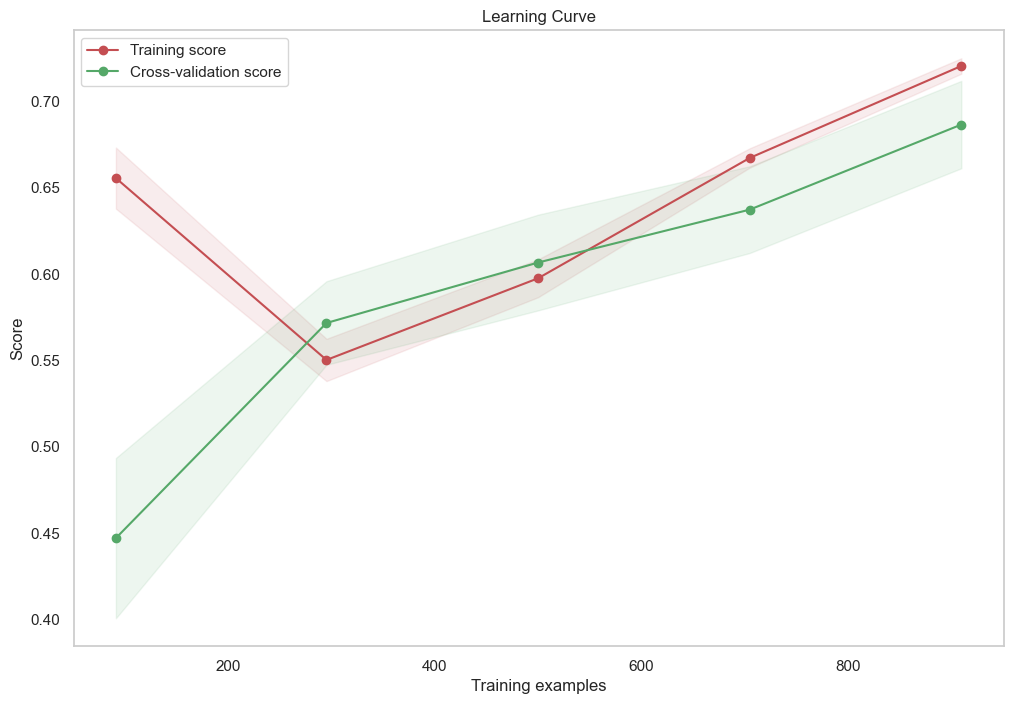

In [18]:
def plot_learning_curve(estimator, X, y, cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure(figsize=(12, 8))
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores = []
    test_scores = []

    for i in range(y.shape[1]):
        train_sizes, train_scores_i, test_scores_i = learning_curve(
            estimator, X, y[:, i], cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1')
        
        train_scores.append(train_scores_i)
        test_scores.append(test_scores_i)

    train_scores = np.mean(train_scores, axis=0)
    test_scores = np.mean(test_scores, axis=0)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")

    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
plot_learning_curve(SVC(probability=True, class_weight='balanced'), X_pca, y, cv)

Example of Overfitting

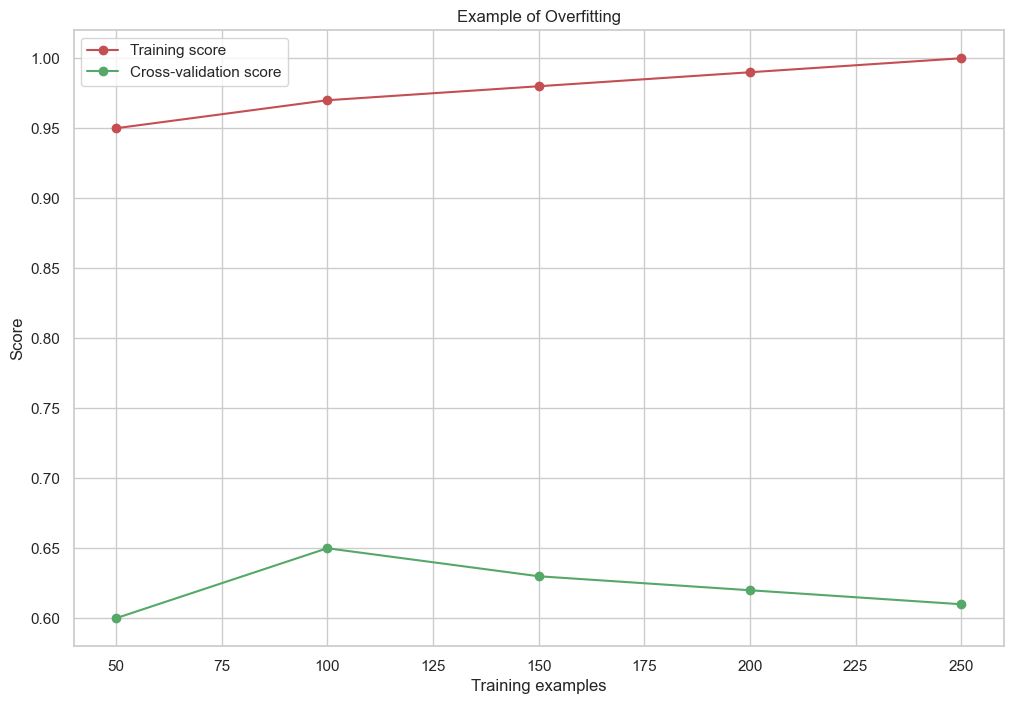

In [19]:
# Example plot for overfitting (simulated)
train_sizes = [50, 100, 150, 200, 250]
train_scores = [0.95, 0.97, 0.98, 0.99, 1.0]
test_scores = [0.6, 0.65, 0.63, 0.62, 0.61]

plt.figure(figsize=(12, 8))
plt.title("Example of Overfitting")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.plot(train_sizes, train_scores, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()


Example of Good fit

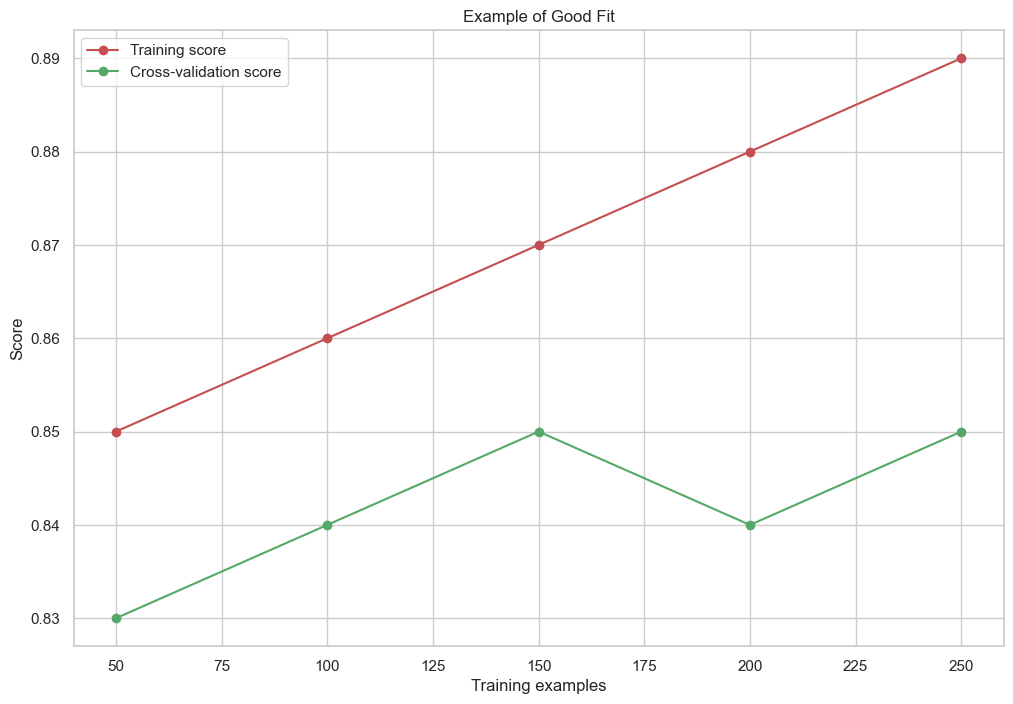

In [20]:
# Example plot for good fit (simulated)
train_sizes = [50, 100, 150, 200, 250]
train_scores = [0.85, 0.86, 0.87, 0.88, 0.89]
test_scores = [0.83, 0.84, 0.85, 0.84, 0.85]

plt.figure(figsize=(12, 8))
plt.title("Example of Good Fit")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.plot(train_sizes, train_scores, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()


Example of Underfit

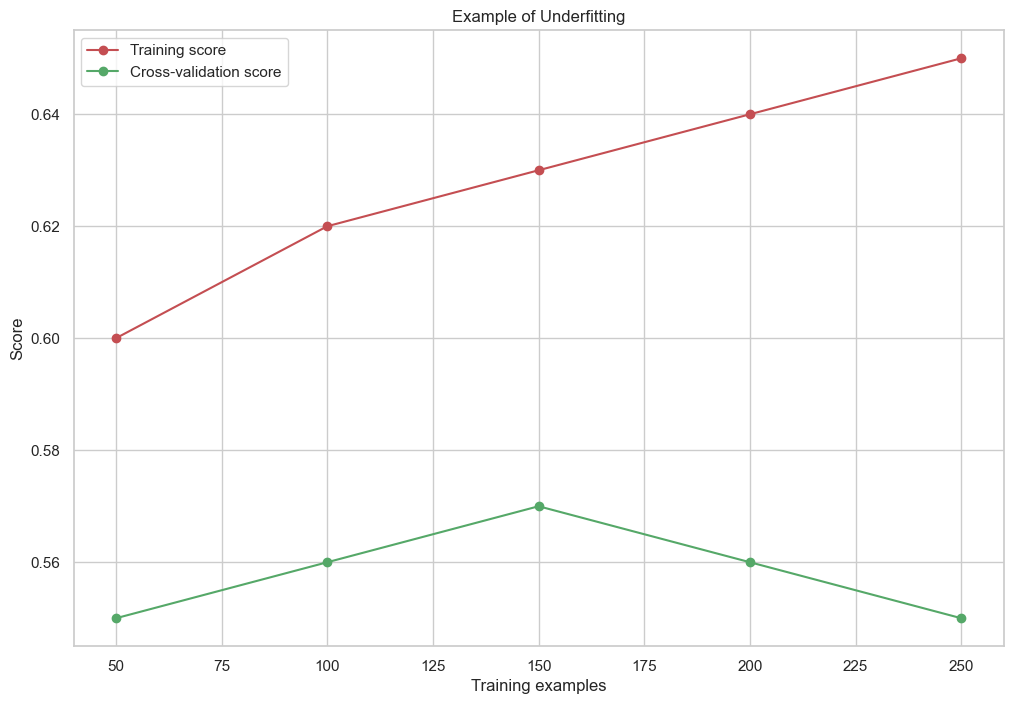

In [21]:
train_sizes = [50, 100, 150, 200, 250]
train_scores = [0.6, 0.62, 0.63, 0.64, 0.65]
test_scores = [0.55, 0.56, 0.57, 0.56, 0.55]

plt.figure(figsize=(12, 8))
plt.title("Example of Underfitting")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.plot(train_sizes, train_scores, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()